In [7]:
%load_ext autoreload
%autoreload 2

import torch

from torch.utils.data import DataLoader

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.image import plot_losses, plot_images
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import Trainer, create_optimizer
from src.deep_ad.transforms import create_training_transform, create_validation_transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load the configuration
# config = Config(root_dir="..", config_path="../save/checkpoints/7_class_10_1_batch_weights_init/config.yml")
config = Config(root_dir="..", config_path="../default_config.yml")

### Test the trainer

In [16]:
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(config, train_transform, val_transform, classes=[10])

In [17]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [18]:
# Load the model
model = DeepCNN(config).to(config.device)
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")

Model has 1,447,713 parameters


In [20]:
# Create the trainer
run_name = f"10_class_10_1_batch_weights_init_bn_out_norm"
print(f"Run name: {run_name}\n")
train_epochs = 1000
limit_batches = 1
save_epochs = [100, 200, 300, 400, 500, 1000]
config.train_epochs = train_epochs
print(config)
trainer = Trainer(
    config,
    model,
    train_dataloader,
    val_dataloader,
    run_name=run_name,
    train_epochs=train_epochs,
    limit_batches=limit_batches,
    save_epochs=save_epochs,
)

Run name: 10_class_10_1_batch_weights_init_bn_out_norm

Datasets:
dagm_lengths: [0.8, 0.1, 0.1]
raw_patch_size: 176
patch_size: 128
ppi: 4
patches_iou_threshold: 0.05

PyTorch:
seed: 42
device: cuda

Training:
batch_size: 32
init_weights: True
loss_type: l1_norm
loss_Lambda: 0.9
loss_N: 16384
optim_lr: 0.0002
optim_adam_betas: (0.9, 0.999)
optim_adam_eps: 1e-08
train_epochs: 1000


In [21]:
# Start training
%matplotlib inline
train_losses, val_losses = trainer.train()

	Batch   1/100: Loss 0.001875
Epoch   1/3: Train Loss 0.001875, Val Loss 0.001726, time 4.984 s
Checkpoint saved at '..\save\checkpoints\test\best.pt'
	Batch   1/100: Loss 0.001105
Epoch   2/3: Train Loss 0.001105, Val Loss 0.001778, time 5.511 s
	Batch   1/100: Loss 0.000910
Epoch   3/3: Train Loss 0.000910, Val Loss 0.001869, time 5.420 s
Checkpoint saved at '..\save\checkpoints\test\epoch_3.pt'
Training finished.


In [22]:
# Clear cache after training
torch.cuda.empty_cache()

In [24]:
# Load the best model
model_best = DeepCNN(config).to(config.device)
optimizer_best = create_optimizer(model_best, config)
checkpoint_name = "epoch_1000"
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, name=checkpoint_name),
)

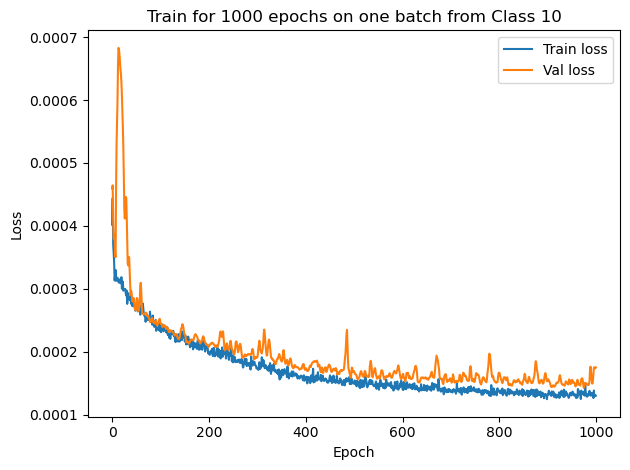

In [30]:
%matplotlib inline
import os

# Plot the losses
save_dir = os.path.join(config.root_dir, "save", "plots", run_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plot_losses(
    torch.asarray(train_losses), 
    torch.asarray(val_losses), 
    title="Train for 1000 epochs on one batch from Class 10", 
    save_path=os.path.join(save_dir, f"{checkpoint_name}_losses.png"),
)

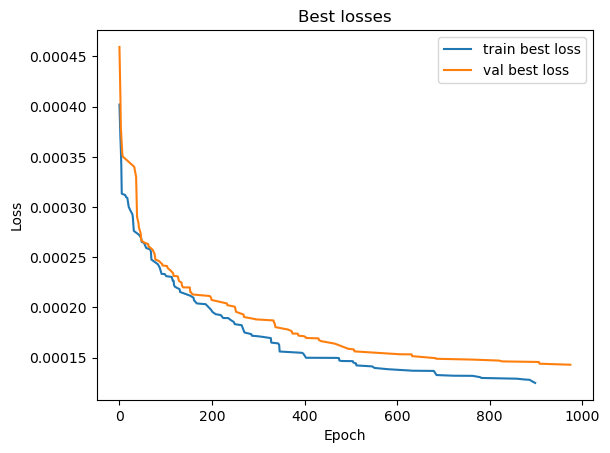

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

losses_minimum = np.minimum.accumulate(train_losses)
change_indices = (np.roll(losses_minimum, 1) != losses_minimum).nonzero()[0]
best_losses = np.array(train_losses)[change_indices]
val_losses_minimum = np.minimum.accumulate(val_losses)
val_change_indices = (np.roll(val_losses_minimum, 1) != val_losses_minimum).nonzero()[0]
best_val_losses = np.array(val_losses)[val_change_indices]

plt.plot(change_indices, best_losses, label="train best loss")
plt.plot(val_change_indices, best_val_losses, label="val best loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Best losses")
plt.savefig(os.path.join(save_dir, f"{checkpoint_name}_best_losses.png"), dpi=1000)
plt.show()

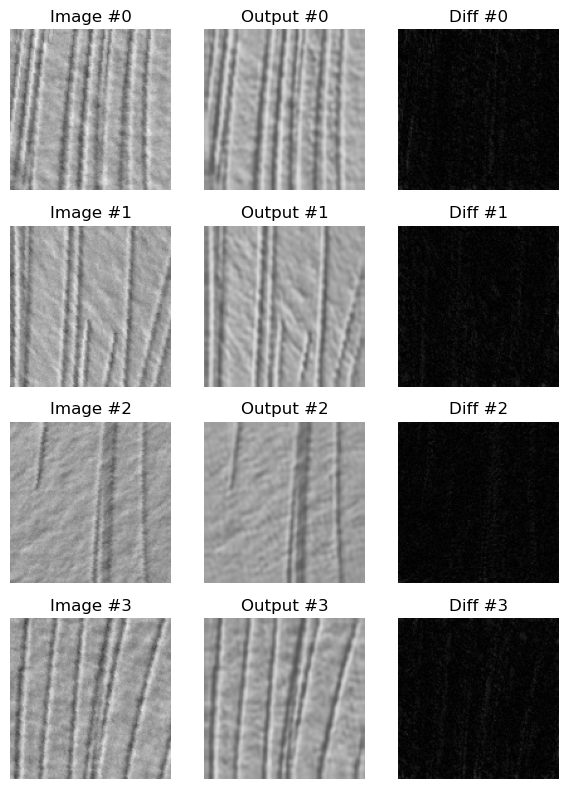

In [64]:
def flatten(xs):
    return [x for ys in xs for x in ys]

images, keys = next(iter(train_dataloader))
input_images = []
outputs = []
for i in range(4):
    image = images[i]
    input_images.append(image.squeeze().detach().cpu().numpy())
    input = image.unsqueeze(0).to(config.device)
    input[48:80, 48:80] = 0
    output = model(input)
    output = trainer._normalize_to_mean_std(
        output.cpu(), image.mean(dim=(-2, -1), keepdim=True), image.std(dim=(-2, -1), keepdim=True)
    )
    outputs.append(output.squeeze().detach().cpu().numpy())
diff = np.abs(np.array(input_images) - np.array(outputs))
titles = flatten([[f"Image #{i}", f"Output #{i}", f"Diff #{i}"] for i in range(4)])
plot_images(flatten(list(zip(input_images, outputs, diff))), titles, rows=4, cols=3, figsize=(6, 8), show=False)
plt.savefig(os.path.join(save_dir, f"{checkpoint_name}_eval.png"), dpi=1000)
plt.show()